In [1]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [2]:
import tensorflow as tf
print(tf.__version__)

2.1.0


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Input, Dense, SimpleRNN,GRU,Flatten, LSTM
from tensorflow.keras.models import  Model
from tensorflow.keras.optimizers import SGD, Adam

In [0]:
# We create a synthetic data
series = np.sin((0.1 * np.arange(400))**2)

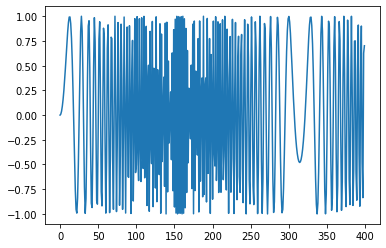

In [24]:
plt.plot(series)

In [25]:
#building dataset
T = 10 #we use 10 window to predict
D = 1
X = []
Y = []

for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1,T)
Y = np.array(Y)
N = len(X)
print(X.shape, "::", Y.shape)

(390, 10) :: (390,)


In [26]:
# Auto regressive linear model
i = Input(shape=(T,))
x = Dense(1)(i)
model = Model(i,x)
model.compile(
    loss="mse",
    optimizer=Adam(learning_rate=0.1)
)
# train RNN
# for time series, we don't split using sklearn because we want to predict in next x step
r = model.fit(
    X[:-N//2], Y[:-N//2],
    epochs=80,
    validation_data=(X[-N//2:], Y[-N//2:])
)


Train on 195 samples, validate on 195 samples
Epoch 1/80
195/195 [==============================] - 0s 1ms/sample - loss: 0.7234 - val_loss: 0.7256
Epoch 2/80
195/195 [==============================] - 0s 227us/sample - loss: 0.5967 - val_loss: 0.6092
Epoch 3/80
195/195 [==============================] - 0s 199us/sample - loss: 0.6007 - val_loss: 0.5610
Epoch 4/80
195/195 [==============================] - 0s 200us/sample - loss: 0.5530 - val_loss: 0.6792
Epoch 5/80
195/195 [==============================] - 0s 205us/sample - loss: 0.5322 - val_loss: 0.7026
Epoch 6/80
195/195 [==============================] - 0s 211us/sample - loss: 0.5242 - val_loss: 0.6695
Epoch 7/80
195/195 [==============================] - 0s 191us/sample - loss: 0.5603 - val_loss: 0.6365
Epoch 8/80
195/195 [==============================] - 0s 174us/sample - loss: 0.5508 - val_loss: 0.5619
Epoch 9/80
195/195 [==============================] - 0s 184us/sample - loss: 0.5497 - val_loss: 0.5776
Epoch 10/80
195/195 

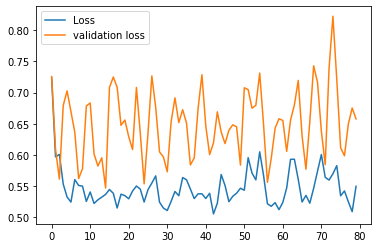

In [27]:
# plot loss
plt.plot(r.history["loss"], label="Loss")
plt.plot(r.history["val_loss"], label="validation loss")
plt.legend()

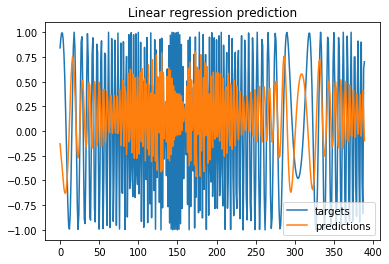

In [28]:
# One step forecast using true target
output = model.predict(X)
predictions = output[:,0]

plt.plot(Y,label="targets")
plt.plot(predictions, label="predictions")
plt.title("Linear regression prediction")
plt.legend()
plt.show()

In [0]:
# here our prediction is very bad

In [0]:
# single step forecast - wrong forcast using true target
validation_target = Y[-N//2:]
validation_predictions=[]
# first validation input index
i = -N // 2
while len(validation_predictions) < len(validation_target):
  p = model.predict(X[i].reshape(1,-1))[0,0] #1x1 array i.e. scalar
  # update prediciton list
  i +=1
  validation_predictions.append(p) 

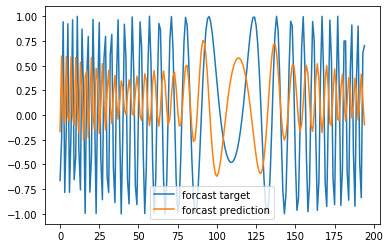

In [31]:
plt.plot(validation_target, label="forcast target")
plt.plot(validation_predictions, label="forcast prediction")
plt.legend()

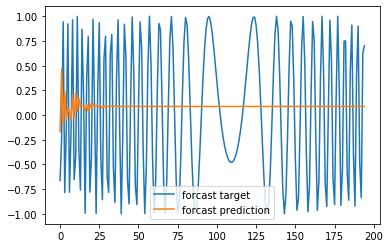

In [32]:
# Multi step forecast -- correct way forcast using true target
validation_target = Y[-N//2:]
validation_predictions=[]
# last train input
last_x = X[-N // 2] # 1D array of length T
while len(validation_predictions) < len(validation_target):
  p = model.predict(last_x.reshape(1,-1))[0,0] #1x1 array i.e. scalar
  # update prediciton list
  validation_predictions.append(p) 
  # make new input
  last_x = np.roll(last_x,-1)
  last_x[-1] = p

plt.plot(validation_target, label="forcast target")
plt.plot(validation_predictions, label="forcast prediction")
plt.legend()

**We can clearly see that linear model does terrible job in forecasting. Now we will see how well RNN does.**

*  *** First we try SimpleRNN***



In [33]:
# make NxTxD
X = X.reshape(-1,T,D)
i = Input(shape=(T,D))
x = SimpleRNN(10)(i)
x = Dense(1)(x)
model = Model(i, x)
model.compile(
    loss="mse",
    optimizer=Adam(learning_rate=0.05)
)
# now we train our rnn model
r = model.fit(
    X[:-N//2], Y[:-N//2],
    batch_size=32,
    epochs=250,
    validation_data=(X[-N//2:], Y[-N//2:])
)


Train on 195 samples, validate on 195 samples
Epoch 1/250
195/195 [==============================] - 1s 5ms/sample - loss: 0.6797 - val_loss: 0.7409
Epoch 2/250
195/195 [==============================] - 0s 392us/sample - loss: 0.5874 - val_loss: 0.5385
Epoch 3/250
195/195 [==============================] - 0s 415us/sample - loss: 0.4550 - val_loss: 0.5293
Epoch 4/250
195/195 [==============================] - 0s 447us/sample - loss: 0.3618 - val_loss: 0.4498
Epoch 5/250
195/195 [==============================] - 0s 433us/sample - loss: 0.3401 - val_loss: 0.3755
Epoch 6/250
195/195 [==============================] - 0s 441us/sample - loss: 0.2637 - val_loss: 0.3106
Epoch 7/250
195/195 [==============================] - 0s 425us/sample - loss: 0.2125 - val_loss: 0.2958
Epoch 8/250
195/195 [==============================] - 0s 510us/sample - loss: 0.1430 - val_loss: 0.1671
Epoch 9/250
195/195 [==============================] - 0s 364us/sample - loss: 0.0996 - val_loss: 0.1405
Epoch 10/25

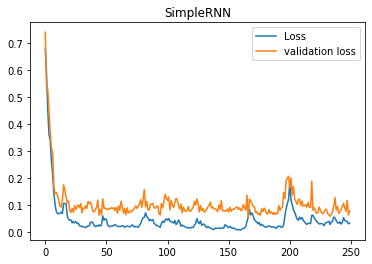

In [34]:
# plot loss
plt.plot(r.history["loss"], label="Loss")
plt.plot(r.history["val_loss"], label="validation loss")
plt.title("SimpleRNN")
plt.legend()
plt.show()

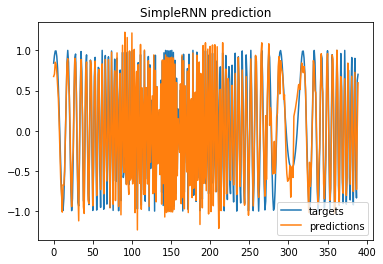

In [36]:
# One step forecast using true target
output = model.predict(X)
predictions = output[:,0]

plt.plot(Y,label="targets")
plt.plot(predictions, label="predictions")
plt.title("SimpleRNN prediction")
plt.legend()
plt.show()

We can clearly see RNN doing better than before.

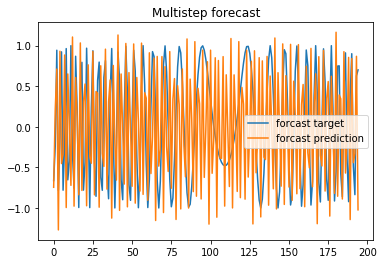

In [39]:
# Multi step forecast -- correct way forcast using true target
validation_target = Y[-N//2:]
validation_predictions=[]
# last train input
last_x = X[-N // 2] # 1D array of length T
while len(validation_predictions) < len(validation_target):
  p = model.predict(last_x.reshape(1,T,1))[0,0] #1x1 array i.e. scalar
  # update prediciton list
  validation_predictions.append(p) 
  # make new input
  last_x = np.roll(last_x,-1)
  last_x[-1] = p

plt.plot(validation_target, label="forcast target")
plt.plot(validation_predictions, label="forcast prediction")
plt.title("Multistep forecast")
plt.legend()
plt.show()

**Even with the multistep forecast, we have better result compared to linear model**

**Now we will apply LSTM **

In [40]:
series = np.sin((0.1 * np.arange(400))**2)
#building dataset
T = 10 #we use 10 window to predict
D = 1
X = []
Y = []

for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1,T)
Y = np.array(Y)
N = len(X)
print(X.shape, "::", Y.shape)

(390, 10) :: (390,)


In [41]:
# make NxTxD
X = X.reshape(-1,T,D)
i = Input(shape=(T,D))
x = LSTM(10)(i)
x = Dense(1)(x)
model = Model(i, x)
model.compile(
    loss="mse",
    optimizer=Adam(learning_rate=0.05)
)
# now we train our rnn model LSTM
r = model.fit(
    X[:-N//2], Y[:-N//2],
    batch_size=32,
    epochs=250,
    validation_data=(X[-N//2:], Y[-N//2:])
)


Train on 195 samples, validate on 195 samples
Epoch 1/250
195/195 [==============================] - 6s 31ms/sample - loss: 0.5945 - val_loss: 0.5058
Epoch 2/250
195/195 [==============================] - 0s 253us/sample - loss: 0.5290 - val_loss: 0.4884
Epoch 3/250
195/195 [==============================] - 0s 235us/sample - loss: 0.4934 - val_loss: 0.5433
Epoch 4/250
195/195 [==============================] - 0s 235us/sample - loss: 0.4972 - val_loss: 0.6157
Epoch 5/250
195/195 [==============================] - 0s 248us/sample - loss: 0.4608 - val_loss: 0.5705
Epoch 6/250
195/195 [==============================] - 0s 258us/sample - loss: 0.4054 - val_loss: 0.4850
Epoch 7/250
195/195 [==============================] - 0s 251us/sample - loss: 0.3033 - val_loss: 0.4163
Epoch 8/250
195/195 [==============================] - 0s 249us/sample - loss: 0.2190 - val_loss: 0.2932
Epoch 9/250
195/195 [==============================] - 0s 241us/sample - loss: 0.1780 - val_loss: 0.2547
Epoch 10/2

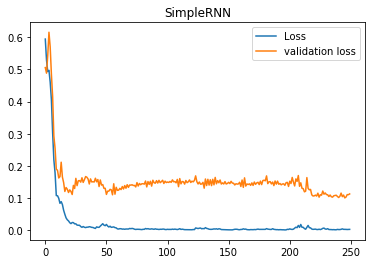

In [42]:
# plot loss
plt.plot(r.history["loss"], label="Loss")
plt.plot(r.history["val_loss"], label="validation loss")
plt.title("SimpleRNN")
plt.legend()
plt.show()

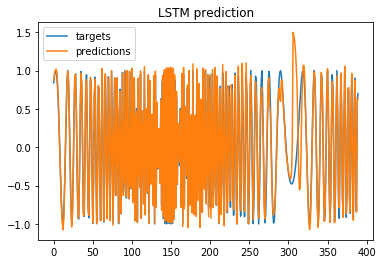

In [43]:
# One step forecast using true target
output = model.predict(X)
predictions = output[:,0]

plt.plot(Y,label="targets")
plt.plot(predictions, label="predictions")
plt.title("LSTM prediction")
plt.legend()
plt.show()

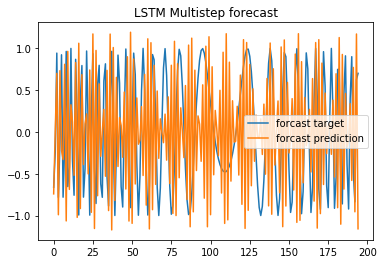

In [44]:
# Multi step forecast -- correct way forcast using true target
validation_target = Y[-N//2:]
validation_predictions=[]
# last train input
last_x = X[-N // 2] # 1D array of length T
while len(validation_predictions) < len(validation_target):
  p = model.predict(last_x.reshape(1,T,1))[0,0] #1x1 array i.e. scalar
  # update prediciton list
  validation_predictions.append(p) 
  # make new input
  last_x = np.roll(last_x,-1)
  last_x[-1] = p

plt.plot(validation_target, label="forcast target")
plt.plot(validation_predictions, label="forcast prediction")
plt.title("LSTM Multistep forecast")
plt.legend()
plt.show()